<h1 align="center"><font size="5">Classification with Python and Scikit-Learn</font></h1>

In this notebook are applied several Machine Learning algorithms in order to predict whether a loan case will be paid off or not.

A historical dataset(provided by IBM) from previous loan applications is fed to different classifiers, after a previous data cleaning and manipulation.
The goal is to evaluate the accuracy of each algorithm and check which one presents a better performance in the stated objective.

The following algorithms will be used:
- K-Nearest Neighbour
- Decision Tree
- Support Vector Machine
- Logistic Regression

To measure the accuracy of each classifier, the following metrics will be used:
- Jaccard index
- F1-score
- LogLoss

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn import metrics
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

To get the dataset:

In [2]:
#!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

#### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.columns[3:]

Index(['Principal', 'terms', 'effective_date', 'due_date', 'age', 'education',
       'Gender'],
      dtype='object')

In [5]:
df.shape

(346, 10)

#### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Data visualization and pre-processing



In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [8]:
df.isnull().values.any()

False

260 people have paid off the loan on time while 86 have gone into collection 


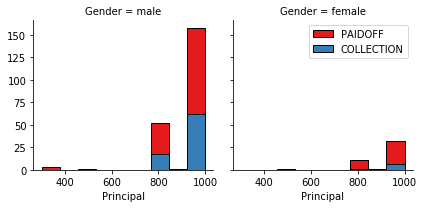

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [10]:
df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

In [11]:
df.groupby(['Gender'])['Principal'].value_counts()

Gender  Principal
female  1000          38
        800           12
        500            1
        900            1
male    1000         220
        800           69
        300            3
        500            1
        900            1
Name: Principal, dtype: int64

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts()

Gender  loan_status
female  PAIDOFF         45
        COLLECTION       7
male    PAIDOFF        215
        COLLECTION      79
Name: loan_status, dtype: int64

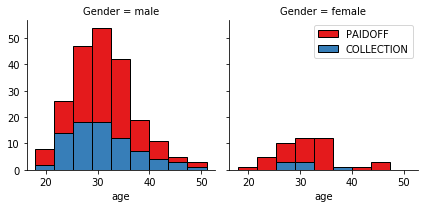

In [13]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

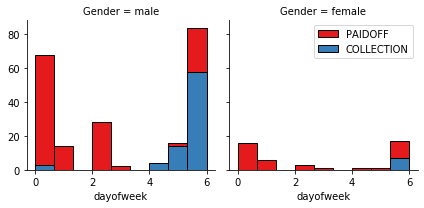

In [14]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


From the plots we can see that people who get the loan at the end of the week dont pay it off, so feature binarization is used to set a threshold values less then day-4(Friday).

In [15]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


#### Convert Categorical features to numerical values

Lets look at gender:

In [16]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Converting male to 0 and female to 1:


In [17]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### One Hot Encoding  

In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [19]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


- Using one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame

In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define the features set ***X***:

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

#### Data Normalization 

In [23]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Classification

Spliting the dataset into training and validation sets.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.2,random_state=4)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(276, 8) (276,)
(70, 8) (70,)


**Note**: Mean accuracy will be used for hyperparameters tuning. 

### K-Nearest Neighbor(KNN)


In [25]:
from sklearn.neighbors import KNeighborsClassifier

Looping to find the K that provides the highest accuracy.


In [26]:
Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors= n, leaf_size=30).fit(X_train,y_train)
    y_pred = neigh.predict(X_valid)
    
    mean_acc[n-1] = metrics.accuracy_score(y_valid, y_pred)
    std_acc[n-1] = np.std(y_pred == y_valid)/np.sqrt(y_pred.shape[0])

In [27]:
mean_acc, mean_acc.argmax()

(array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
        0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
        0.7       ]),
 6)

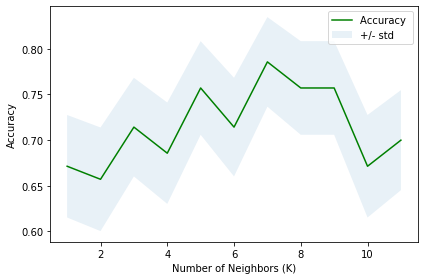

In [28]:
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc - 1*std_acc, mean_acc+1*std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- std'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show();

In [29]:
print("The best accuracy was", round(mean_acc.max(),3), "with k =", mean_acc.argmax()+1)

The best accuracy was 0.786 with k = 7


### Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
loanTree = DecisionTreeClassifier(max_depth=4)
loanTree

DecisionTreeClassifier(max_depth=4)

In order to not overfit, we should limit the maximum depth of the model. Generally, minimazing the 'max_' parameters and maximazing the 'min_' parameters is the best approach for the regularization decision trees.

In [58]:
loanTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [59]:
predTree = loanTree.predict(X_valid)
print("DecisionTrees's Accuracy:", metrics.accuracy_score(y_valid, predTree))

DecisionTrees's Accuracy: 0.6142857142857143


**Note:** It should be mentioned that exists other hyperparameters configuration which improves the accuracy above. However, we are interested in the best performance possible in new data, data which hasn't be seen yet by the model.
That configurations of hyperparameters lead to overfitting, hence, decreasing the accuracy on the evaluation set significantly.
The *max_depth* parameter (as well as the other parameters in the other specifics algorithms) was not chosen considering the mean accuracy in the training phase but to maximize the accuracy given by the metrics selected in the model evaluation presented above (meaning that some cells were not done sequentially obviously). A loop to determine the best configuration of hyperparameters that leads to the optimum performance could also be done in this matter.

In [34]:
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg

In [35]:
np.unique(y_train)

array(['COLLECTION', 'PAIDOFF'], dtype=object)

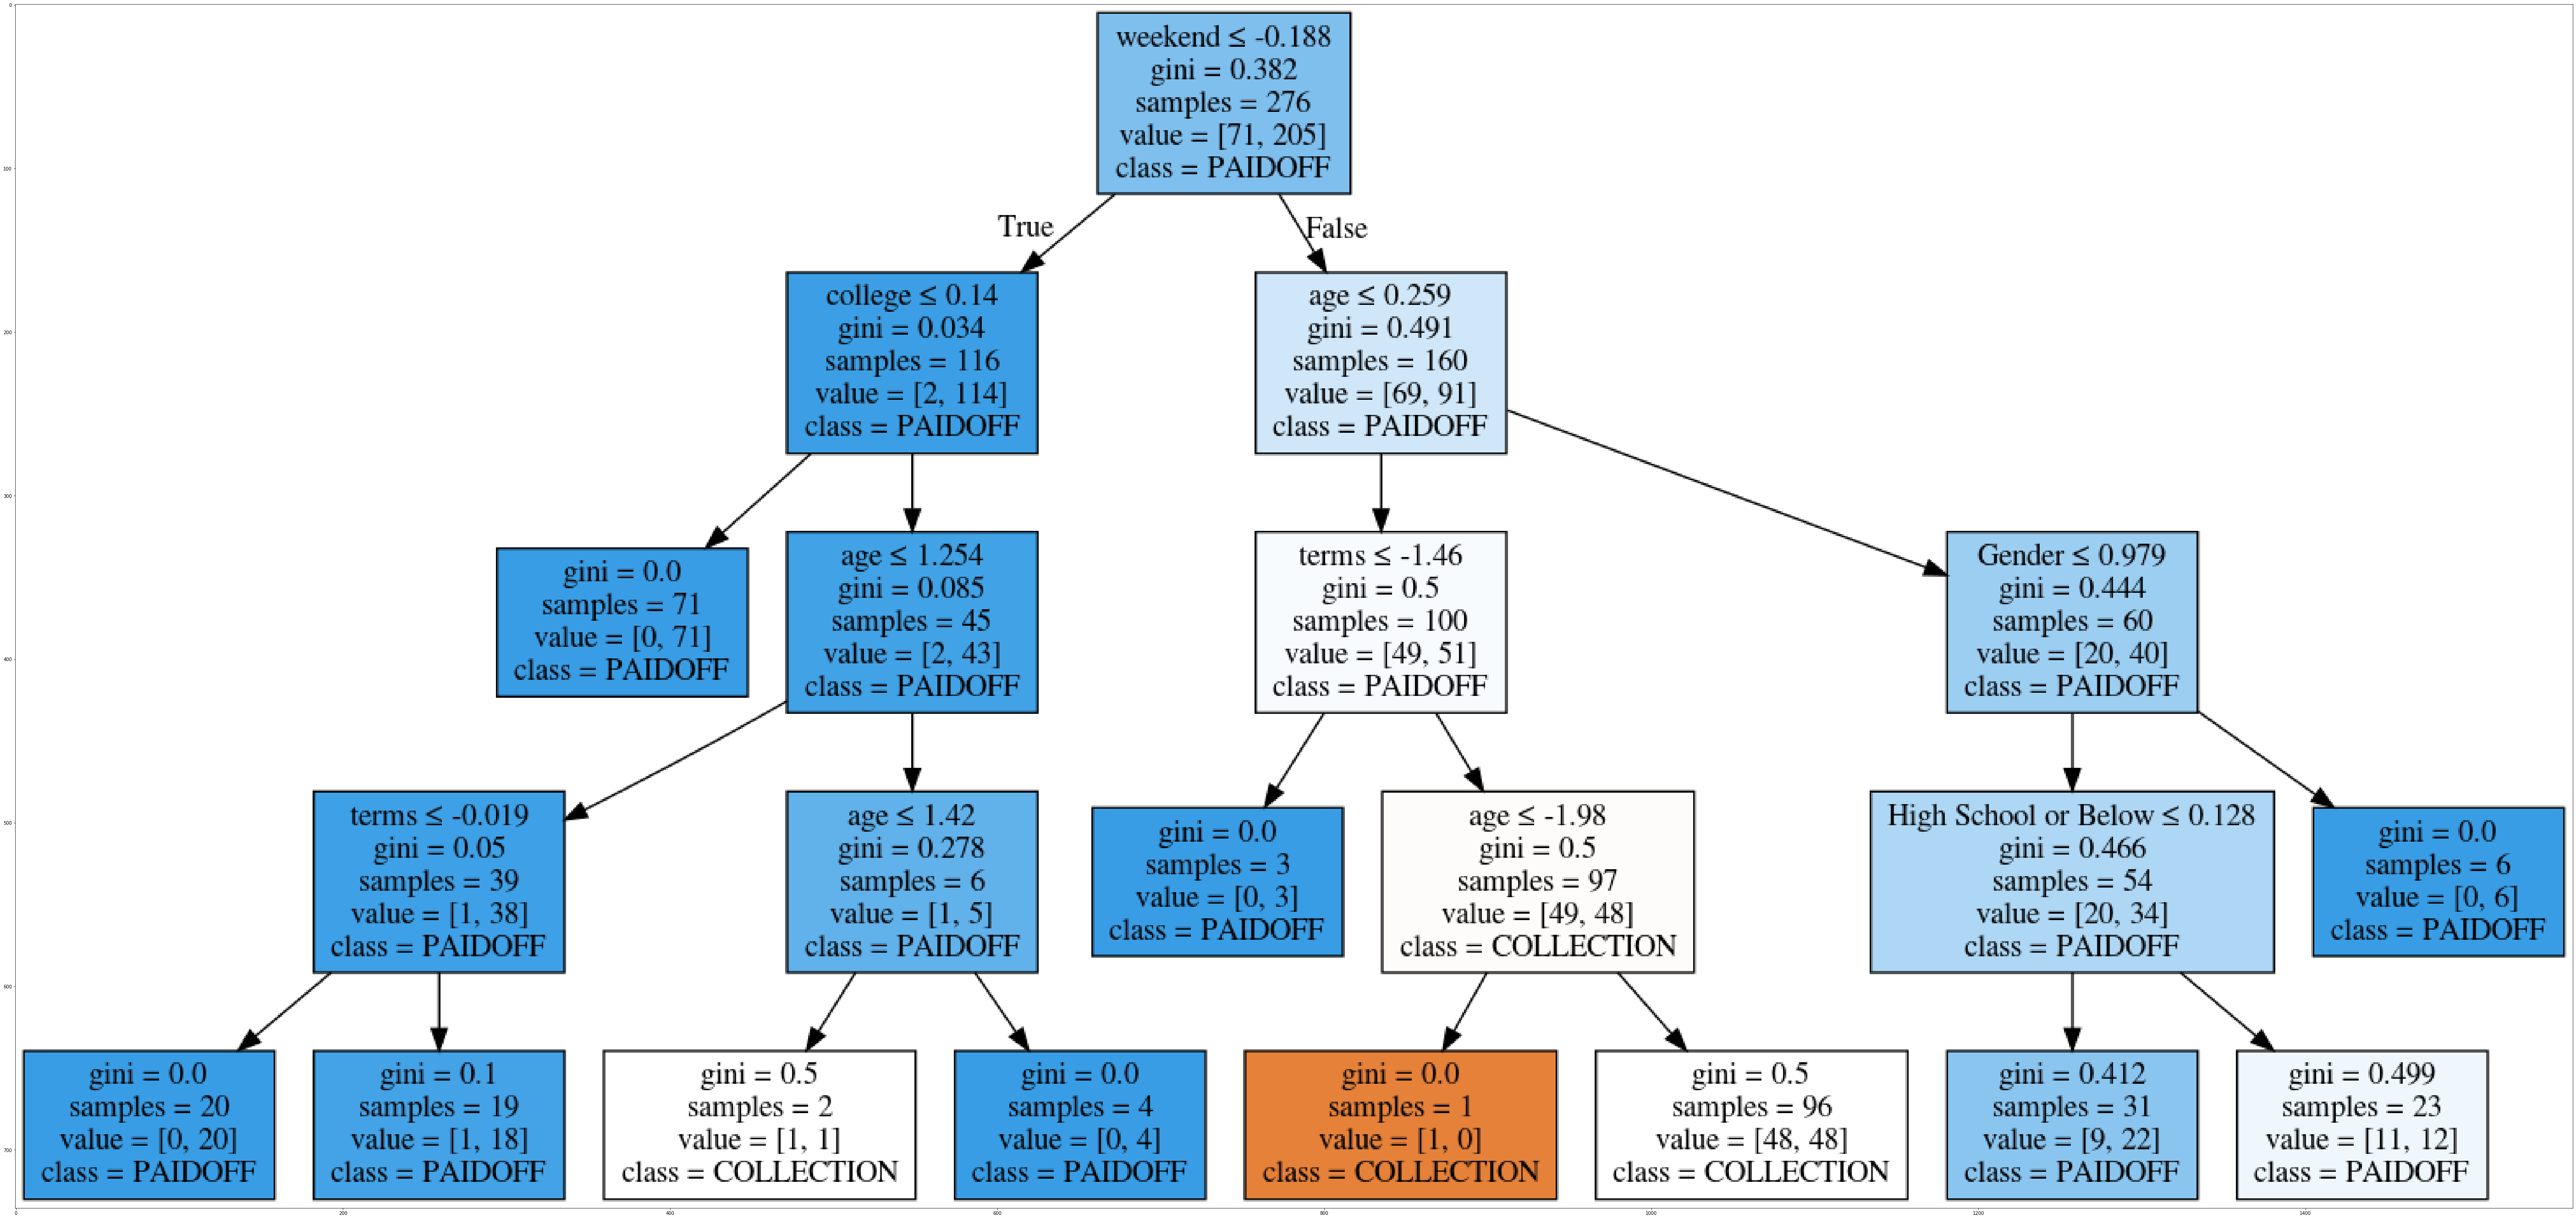

In [36]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[:]
targetNames = df["loan_status"].unique().tolist()
out = tree.export_graphviz(loanTree,feature_names=featureNames,
                          out_file=dot_data,
                          class_names= np.unique(y_train),
                          filled=True,
                          special_characters=True,
                          rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100,200))
plt.imshow(img, interpolation='nearest')

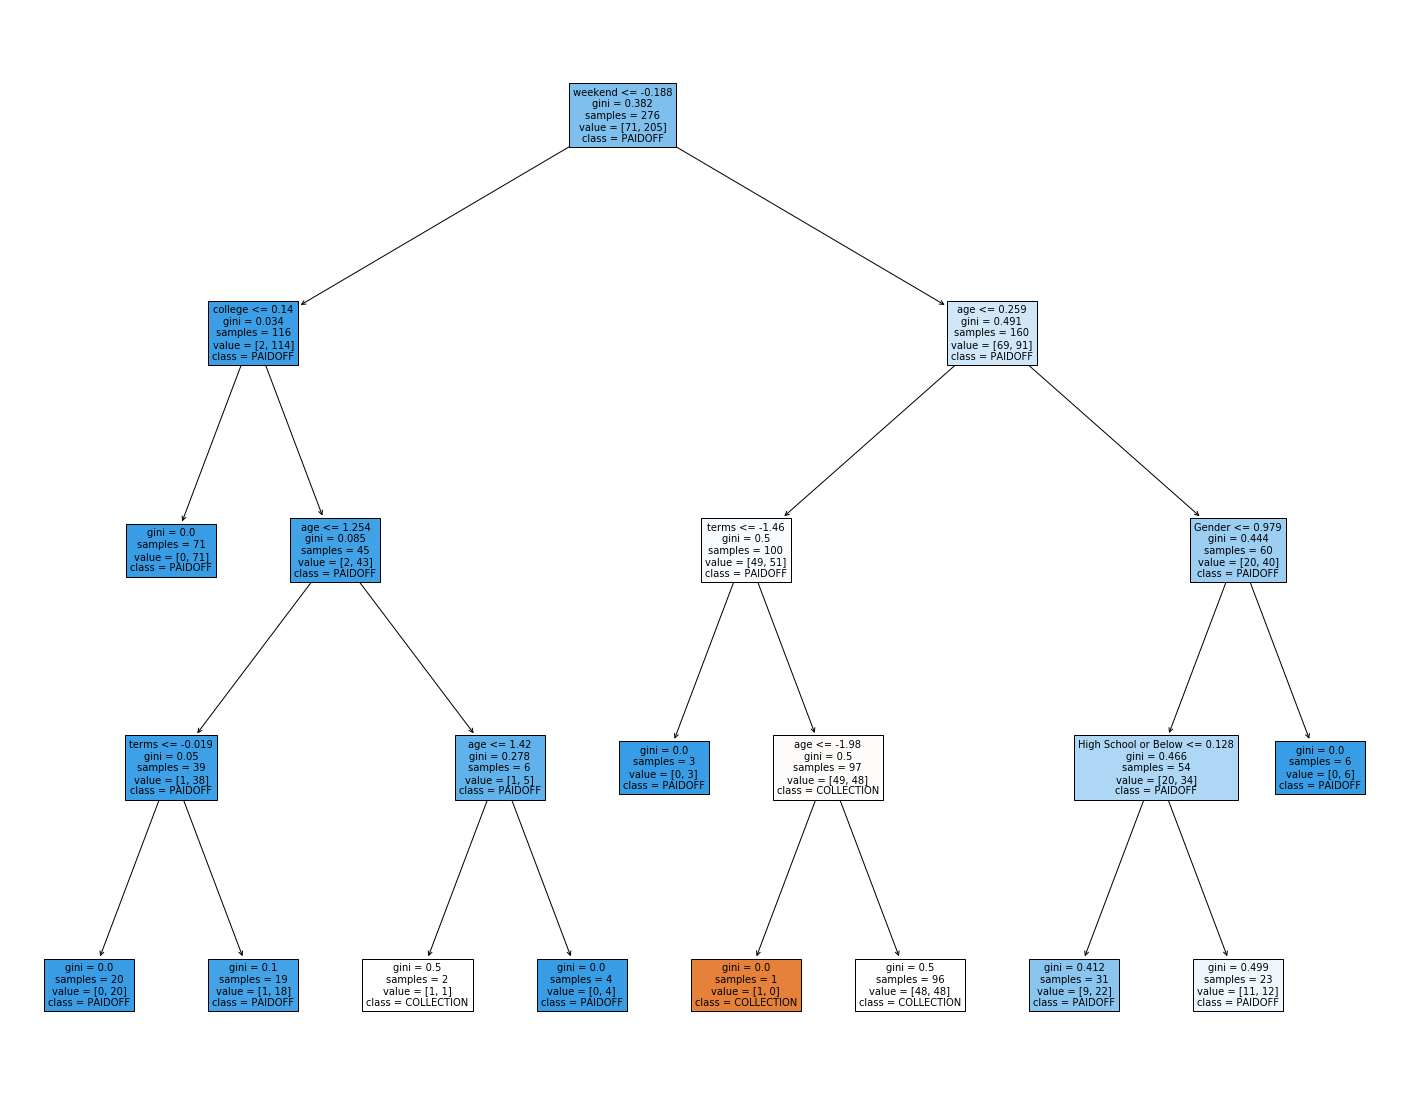

In [37]:
#another way of plotting
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(loanTree, 
                   feature_names=Feature.columns[:],  
                   class_names=np.unique(y_train),
                   filled=True)

### Support Vector Machine

In [38]:
from sklearn import svm
loan_svm = svm.SVC(kernel='rbf')
loan_svm.fit(X_train, y_train)

SVC()

In [39]:
Pred_svm = loan_svm.predict(X_valid)
Pred_svm[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [40]:
metrics.accuracy_score(y_valid, predTree)

0.6142857142857143

Among all available kernels, **RBF** is the one which gives the highest accuracy.

### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
loan_LogReg = LogisticRegression(random_state=4).fit(X_train,y_train)
loan_LogReg

LogisticRegression(random_state=4)

In [43]:
Pred_LogReg = loan_LogReg.predict(X_valid)
loan_LogReg.score(X_valid, y_valid)

0.7285714285714285

## Model Evaluation

Proceding to the classifiers evaluation to check the actual performance on unseen data(test set).

In [44]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

To download and load the test set:

In [45]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

In [46]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [67]:
test_df.shape

(54, 12)

#### Pre-processing

In [47]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [48]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [49]:
kNN_testpred = neigh.predict(test_X)
print("kNN Jaccard index: %.2f" % jaccard_score(test_y, kNN_testpred, pos_label = 'PAIDOFF'))
print("kNN F1-score: %.2f" % f1_score(test_y, kNN_testpred, average='weighted') )

kNN Jaccard index: 0.69
kNN F1-score: 0.67


In [60]:
DT_testPred = loanTree.predict(test_X)
print("DT Jaccard index: %.2f" % jaccard_score(test_y, DT_testPred, pos_label = 'PAIDOFF'))
print("DT F1-score: %.2f" % f1_score(test_y, DT_testPred, average='weighted') )

DT Jaccard index: 0.66
DT F1-score: 0.74


In [51]:
SVM_testPred = loan_svm.predict(test_X)
print("SVM Jaccard index: %.2f" % jaccard_score(test_y, SVM_testPred, pos_label = 'PAIDOFF'))
print("SVM F1-score: %.2f" % f1_score(test_y, SVM_testPred, average='weighted') )

SVM Jaccard index: 0.78
SVM F1-score: 0.76


In [52]:
LogReg_testPred = loan_LogReg.predict(test_X)
LogReg_test_prob = loan_LogReg.predict_proba(test_X)
print("LogReg Jaccard index: %.2f" % jaccard_score(test_y, LogReg_testPred, pos_label = 'PAIDOFF'))
print("LogReg F1-score: %.2f" % f1_score(test_y, LogReg_testPred, average='weighted') )
print("LogReg LogLoss: %.2f" % log_loss(test_y, LogReg_test_prob))

LogReg Jaccard index: 0.74
LogReg F1-score: 0.66
LogReg LogLoss: 0.47


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.65    | 0.63     | NA      |
| Decision Tree      | 0.66    | 0.74     | NA      |
| SVM                | 0.78    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.47    |

The results show that Support Vector Machine presents the better performance on the given task.

Plotting the confusion matrix:

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.80      0.29      0.42        14
     PAIDOFF       0.80      0.97      0.88        40

    accuracy                           0.80        54
   macro avg       0.80      0.63      0.65        54
weighted avg       0.80      0.80      0.76        54

Confusion matrix, without normalization
[[39  1]
 [10  4]]


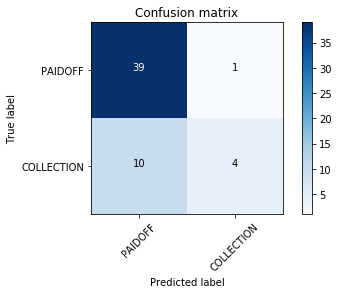

In [66]:
# Computing confusion matrix
svm_matrix = confusion_matrix(test_y, SVM_testPred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(test_y, SVM_testPred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(svm_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

Results of test phase for SVM:
- Total of 54 samples.
- From 40 true labels cases of 'PAIDOFF', the model correctly predicted 39.
- From 14 true labels cases of 'COLLECTION', the model correctly predicted 4.
- Total of 43 accurately predicted samples.